<a href="https://colab.research.google.com/github/hukim1112/MLDL/blob/master/object_detection/SSD_build_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

# A. Backbone 신경망의 전이학습

In [2]:
mobilenet_v2 = MobileNetV2(input_shape=(224,224,3), weights="imagenet", include_top=False)
tf.keras.utils.plot_model(mobilenet_v2, show_shapes=True, expand_nested=True)

start = mobilenet_v2.get_layer("input_1").input
end = mobilenet_v2.get_layer("block_5_add").output
backbone = tf.keras.Model(start, end)

9412608/9406464 [==============================] - 0s 0us/step


# B. Neck 신경망 구현

In [3]:
#input shape (BN, H, W, C)

block1 = tf.keras.Sequential([tf.keras.layers.Conv2D(256, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(256, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,H/2,W/2,512]

block2 = tf.keras.Sequential([tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,H/4,W/4,512]
        
block3 = tf.keras.Sequential([tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2)),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,H/8,W/8,512]
        
block4 = tf.keras.Sequential([tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2)),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(256, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,H/16,W/16,512]

# B. Neck 신경망 연결

In [4]:
input_layer = tf.keras.Input(shape=(224,224,3))
x = backbone(input_layer)
y1 = block1(x)
y2 = block2(y1)
y3 = block3(y2)
y4 = block4(y3)

print("첫 번째 feature map : ", x.shape,\
      "두 번째 feature map : ", y1.shape,\
      "세 번째 feature map : ", y2.shape,\
      "네 번쨰 feature map : ",y3.shape,\
      "다섯번째 feature map : ",y4.shape)

첫 번째 feature map :  (None, 28, 28, 32) 두 번째 feature map :  (None, 14, 14, 256) 세 번째 feature map :  (None, 7, 7, 256) 네 번쨰 feature map :  (None, 3, 3, 256) 다섯번째 feature map :  (None, 1, 1, 256)


# C. head(classification, regression) 신경망 연결



In [5]:
num_classes = 3

#classification head
confs = []
conf = tf.keras.layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(x)
conf = tf.reshape(conf, [-1, 28*28*4,num_classes])
confs.append(conf)
conf = tf.keras.layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y1)
conf = tf.reshape(conf, [-1, 14*14*6,num_classes])
confs.append(conf)
conf = tf.keras.layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y2)
conf = tf.reshape(conf, [-1, 7*7*6,num_classes])
confs.append(conf)
conf = tf.keras.layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y3)
conf = tf.reshape(conf, [-1, 3*3*6,num_classes])
confs.append(conf)
conf = tf.keras.layers.Conv2D(4 * num_classes, kernel_size=1)(y4)
conf = tf.reshape(conf, [-1, 1*1*4,num_classes])
confs.append(conf)


#regression head
locs = []
loc = tf.keras.layers.Conv2D(4 * 4, kernel_size=3, padding='same')(x)
loc = tf.reshape(loc, [-1, 28*28*4,4])
print(loc.shape)
locs.append(loc)
loc = tf.keras.layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y1)
loc = tf.reshape(loc, [-1, 14*14*6,4])
print(loc.shape)
locs.append(loc)
loc = tf.keras.layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y2)
loc = tf.reshape(loc, [-1, 7*7*6,4])
print(loc.shape)
locs.append(loc)
loc = tf.keras.layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y3)
loc = tf.reshape(loc, [-1, 3*3*6,4])
print(loc.shape)
locs.append(loc)
loc = tf.keras.layers.Conv2D(4 * 4, kernel_size=1)(y4)
loc = tf.reshape(loc, [-1, 1*1*4,4])
print(loc.shape)
locs.append(loc)

confs = tf.concat(confs, axis=-2)
locs = tf.concat(locs, axis=-2)

(None, 3136, 4)
(None, 1176, 4)
(None, 294, 4)
(None, 54, 4)
(None, 4, 4)


# D. 최종 모델 빌드

In [6]:
mobilenet_ssd = tf.keras.Model(inputs=[input_layer], outputs=[confs,locs])

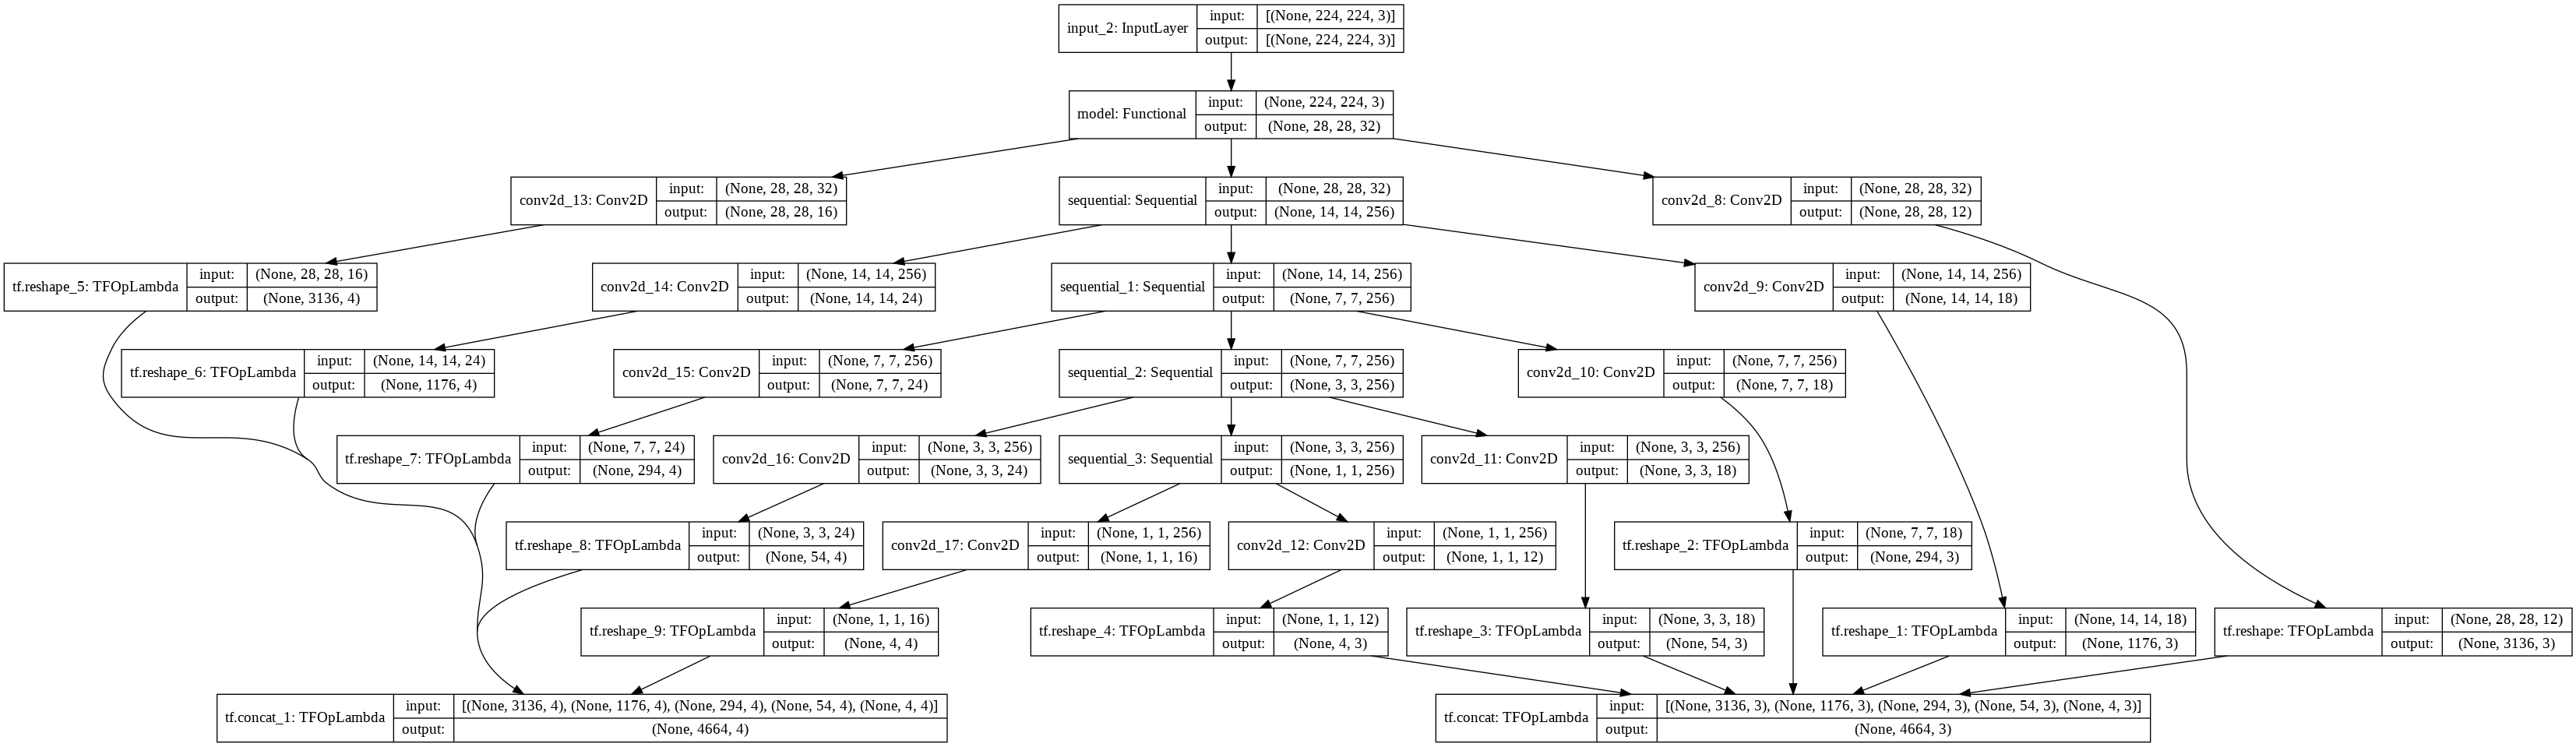

In [7]:
tf.keras.utils.plot_model(mobilenet_ssd, show_shapes=True, expand_nested=False)

In [8]:
mobilenet_ssd.save("ssd.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
